In [1]:
#installations
!pip install scikit-learn tensorflow matplotlib numpy

In [2]:
!pip install pandas

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError

In [4]:
# Load dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [5]:
#finding shape of the dataset
data.shape

(4998, 141)

In [6]:
#splitting training and testing dataset
features = data.drop(140, axis=1)
target = data[140]
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

In [7]:
#scaling the data using MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [8]:
#creating autoencoder subclass by extending Model class from keras
class AutoEncoder(Model):
  def __init__(self, output_units, ldim=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.05),                     
      Dense(32, activation='relu'),
      Dropout(0.05),
      Dense(16, activation='relu'),
      Dropout(0.05),
      Dense(ldim, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.05),
      Dense(32, activation='relu'),
      Dropout(0.05),
      Dense(64, activation='relu'),
      Dropout(0.05),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [14]:
# Initialize and compile model
autoencoder = AutoEncoder(output_units=x_train_scaled.shape[1])
autoencoder.compile(optimizer=Adam(), loss=MeanSquaredError())  # ✅ changed loss to MSE

# 👇 Run a dummy forward pass ONCE to build encoder + decoder
_ = autoencoder(x_train_scaled[:1])   # <— This builds both Sequential submodels

# ✅ Now show the summary
autoencoder.summary()

Model: "auto_encoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (1, 8)                 │        11,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (1, 140)               │        11,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,668 (92.45 KB)

 Trainable params: 23,668 (92.45 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Training the autoencoder
history = autoencoder.fit(
    x_train_scaled, x_train_scaled,
    epochs=50,
    batch_size=32,
    validation_data=(x_test_scaled, x_test_scaled),
    verbose=1
)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0134 - val_loss: 0.0221
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0086 - val_loss: 0.0197
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0061 - val_loss: 0.0189
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 0.0188
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0184
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0169
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - val_loss: 0.0158
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - val_loss: 0.0152
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 0.0152
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0148
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0150
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_l

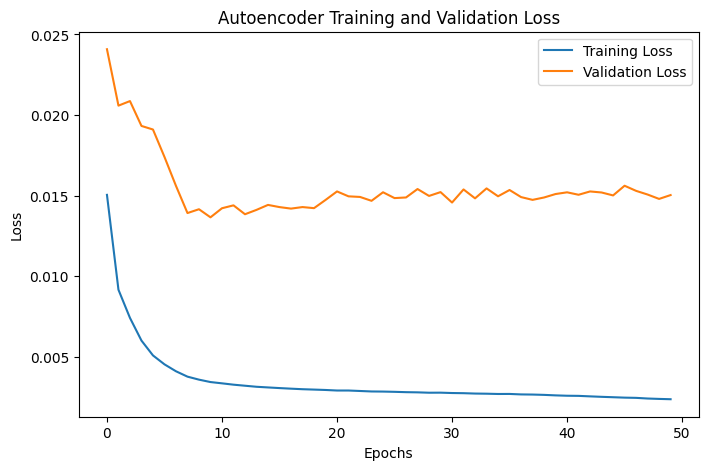

In [11]:
# Plot training and validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Training and Validation Loss')
plt.show()

In [12]:
# Reconstruction and anomaly detection
reconstructions = autoencoder.predict(x_test_scaled)
mse = np.mean(np.square(x_test_scaled - reconstructions), axis=1)

# Define threshold for anomaly detection
threshold = np.mean(mse) + 2*np.std(mse)
print("Reconstruction Error Threshold:", threshold)

# Predict anomalies
predictions = [1 if e > threshold else 0 for e in mse]
print("Number of anomalies detected:", np.sum(predictions))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Reconstruction Error Threshold: 0.04960837955497857
Number of anomalies detected: 15


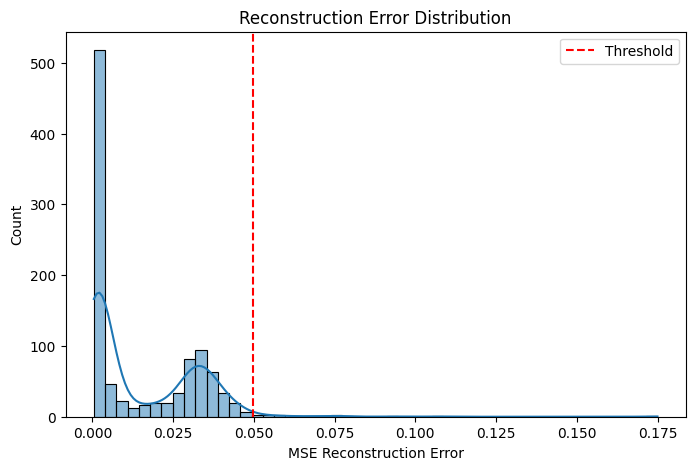

In [13]:
# Plot reconstruction error distribution
!pip install seaborn
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.show()